In [2]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_white"

In [3]:
data = pd.read_csv("C:\\Users\\mohan\\Downloads\\supply_chain_data (2).csv")

In [4]:
print("Initial Dataset Shape:", data.shape)

Initial Dataset Shape: (100, 24)


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location                 10

In [6]:
print(data.isnull().sum())

Product type               0
SKU                        0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64


In [7]:
# Convert data types if necessary
data['SKU'] = data['SKU'].astype(str)
data['Product type'] = data['Product type'].astype('category')
data['Shipping carriers'] = data['Shipping carriers'].astype('category')
data['Supplier name'] = data['Supplier name'].astype('category')
data['Transportation modes'] = data['Transportation modes'].astype('category')
data['Routes'] = data['Routes'].astype('category')

In [8]:
from scipy.stats import zscore
numerical_cols = [
    "Price", "Availability", "Number of products sold", "Revenue generated",
    "Stock levels", "Lead times", "Order quantities", "Shipping times",
    "Shipping costs", "Lead time", "Production volumes",
    "Manufacturing lead time", "Manufacturing costs", "Defect rates", "Costs"
]

# Calculate Z-scores
z_scores = data[numerical_cols].apply(zscore)

# Keep only rows where all Z-scores are less than threshold (e.g., 3)
df_z_filtered = data[(z_scores.abs() < 3).all(axis=1)]

print("Original shape:", data.shape)
print("After Z-score outlier removal:", df_z_filtered.shape)

Original shape: (100, 24)
After Z-score outlier removal: (100, 24)


In [9]:
# Feature engineering: create a 'Date' column if missing (for Prophet)
if 'Date' not in data.columns:
    data['Date'] = pd.date_range(start='2023-01-01', periods=len(data), freq='D')

In [10]:
# Re-check dataset after preprocessing
print("After Preprocessing:")
print(data.info())
print(data.head())

After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Product type             100 non-null    category      
 1   SKU                      100 non-null    object        
 2   Price                    100 non-null    float64       
 3   Availability             100 non-null    int64         
 4   Number of products sold  100 non-null    int64         
 5   Revenue generated        100 non-null    float64       
 6   Customer demographics    100 non-null    object        
 7   Stock levels             100 non-null    int64         
 8   Lead times               100 non-null    int64         
 9   Order quantities         100 non-null    int64         
 10  Shipping times           100 non-null    int64         
 11  Shipping carriers        100 non-null    category      
 12  Shipping costs  

In [11]:
fig = px.scatter(data, x='Price', 
                 y='Revenue generated', 
                 color='Product type', 
                 hover_data=['Number of products sold'], 
                 trendline="ols")
fig.show()

In [12]:
sales_data = data.groupby('Product type', observed=False)['Number of products sold'].sum().reset_index()

pie_chart = px.pie(sales_data, values='Number of products sold', names='Product type', 
                   title='Sales by Product Type', 
                   hover_data=['Number of products sold'],
                   hole=0.5,
                   color_discrete_sequence=px.colors.qualitative.Pastel)

pie_chart.update_traces(textposition='inside', textinfo='percent+label')
pie_chart.show()


In [13]:
avg_lead_time = data.groupby('Product type', observed=True)['Lead time'].mean().reset_index()
avg_manufacturing_costs = data.groupby('Product type', observed=True)['Manufacturing costs'].mean().reset_index()

result = pd.merge(avg_lead_time, avg_manufacturing_costs, on='Product type')
result.rename(columns={
    'Lead time': 'Average Lead Time',
    'Manufacturing costs': 'Average Manufacturing Costs'
}, inplace=True)

print(result)


  Product type  Average Lead Time  Average Manufacturing Costs
0    cosmetics          13.538462                    43.052740
1     haircare          18.705882                    48.457993
2     skincare          18.000000                    48.993157


In [14]:
revenue_chart = px.line(data, x='SKU', 
                        y='Revenue generated', 
                        title='Revenue Generated by SKU')
revenue_chart.show()

In [15]:
stock_chart = px.line(data, x='SKU', 
                      y='Stock levels', 
                      title='Stock Levels by SKU')
stock_chart.show()

In [16]:
order_quantity_chart = px.bar(data, x='SKU', 
                              y='Order quantities', 
                              title='Order Quantity by SKU')
order_quantity_chart.show()

In [17]:
shipping_cost_chart = px.bar(data, x='Shipping carriers', 
                             y='Shipping costs', 
                             title='Shipping Costs by Carrier')
shipping_cost_chart.show()

In [18]:
transportation_chart = px.pie(data, 
                              values='Costs', 
                              names='Transportation modes', 
                              title='Cost Distribution by Transportation Mode',
                              hole=0.5,
                              color_discrete_sequence=px.colors.qualitative.Pastel)
transportation_chart.show()

In [19]:
defect_rates_by_product = data.groupby('Product type', observed=False)['Defect rates'].mean().reset_index()

fig = px.bar(defect_rates_by_product, x='Product type', y='Defect rates',
             title='Average Defect Rates by Product Type')
fig.show()


In [20]:
# Ensure the 'Transportation modes' column is treated as categorical
data['Transportation modes'] = data['Transportation modes'].astype('category')

# Manually group by and compute the mean of 'Defect rates'
grouped_data = data.groupby('Transportation modes', observed=False)['Defect rates'].mean().reset_index()

# Create the pie chart using the grouped data
transportation_chart = px.pie(values=grouped_data["Defect rates"], 
                               names=grouped_data['Transportation modes'], 
                               title='Defect Rates by Transportation Mode',
                               hole=0.5,
                               color_discrete_sequence=px.colors.qualitative.Pastel)

# Display the chart
transportation_chart.show()



C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

10:36:19 - cmdstanpy - INFO - Chain [1] start processing
10:36:19 - cmdstanpy - INFO - Chain [1] done processing


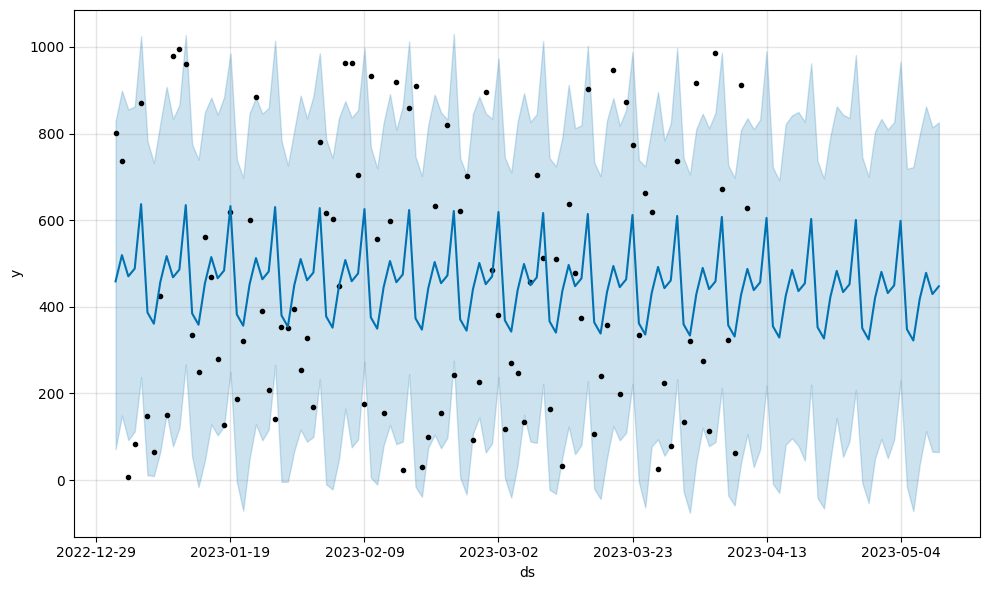

In [21]:
# For Jupyter or interactive environments
%matplotlib inline
import matplotlib.pyplot as plt
from prophet import Prophet
import pandas as pd

# STEP 1: Simulate a Date column (assuming daily records)
data['Date'] = pd.date_range(start='2023-01-01', periods=len(data), freq='D')

# STEP 2: Prepare data for Prophet
time_data = data[['Date', 'Number of products sold']].rename(columns={'Date': 'ds', 'Number of products sold': 'y'})

# STEP 3: Train Prophet model
model = Prophet()
model.fit(time_data)

# STEP 4: Make future dataframe for 30 days
future = model.make_future_dataframe(periods=30)

# STEP 5: Predict and plot
forecast = model.predict(future)
fig = model.plot(forecast)

# Show the plot
plt.show()  # Use plt.show() to render the plot in Jupyter or non-interactive environments


In [22]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Sample distance matrix (replace with real data)
distance_matrix = [
    [0, 20, 42, 35],
    [20, 0, 30, 34],
    [42, 30, 0, 12],
    [35, 34, 12, 0],
]

manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
    return distance_matrix[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

solution = routing.SolveWithParameters(search_parameters)
if solution:
    index = routing.Start(0)
    route = []
    while not routing.IsEnd(index):
        route.append(manager.IndexToNode(index))
        index = solution.Value(routing.NextVar(index))
    route.append(manager.IndexToNode(index))
    print("Optimized Route:", route)


load C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\re2.dll...
load C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\highs.dll...
load C:\Users\mohan\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\ortools.dll...
Optimized Route: [0, 1, 2, 3, 0]


In [23]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Compare only historical part (not future)
actual = time_data['y']
predicted = forecast.loc[:len(actual)-1, 'yhat']

mae = mean_absolute_error(actual, predicted)
rmse = root_mean_squared_error(actual, predicted)  # Updated to use the new function

print(f"📈 Forecast MAE: {mae:.2f}")
print(f"📉 Forecast RMSE: {rmse:.2f}")


📈 Forecast MAE: 248.19
📉 Forecast RMSE: 291.74


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
import numpy as np

# Inventory Turnover Ratio
inventory_turnover = data['Number of products sold'].sum() / data['Stock levels'].mean()

# Average Shipping & Lead Time
avg_shipping_time = data['Shipping times'].mean()
avg_lead_time = data['Lead times'].mean()

# Average Defect Rate
avg_defect_rate = data['Defect rates'].mean()
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number+delta",
    value=inventory_turnover,
    title={"text": "Inventory Turnover Ratio"},
    domain={'row': 0, 'column': 0}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=avg_shipping_time,
    title={"text": "Avg Shipping Time (days)"},
    domain={'row': 0, 'column': 1}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=avg_defect_rate * 100,
    number={'suffix': "%"},
    title={"text": "Average Defect Rate"},
    domain={'row': 1, 'column': 0}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=mae,
    title={"text": "Forecast MAE"},
    domain={'row': 1, 'column': 1}
))

fig.update_layout(
    title="🔍 Supply Chain KPI Dashboard",
    grid={'rows': 2, 'columns': 2},
    height=500
)
fig.show()


